In [46]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr

###########################################################
#       Data Preparation
###########################################################
print("\n\n[Data Preparation]")
mode1 = 'nh'
fout1 = 1026
repo1,rurmode1,dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, fout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']
gal1s = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
hal1s = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

mode2 = 'nh2'
fout2 = 797
repo2,rurmode2,dp2 = mode2repo(mode2)
snap2 = uri.RamsesSnapshot(repo2, fout2, mode=rurmode2)
snap2s = uri.TimeSeries(snap2)
snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']
gal2s = uhmi.HaloMaker.load(snap2, galaxy=True, double_precision=dp2)
hal2s = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp2)


MWA1s = pklload(f"./database/03_MWA1s.pickle")
MWA2s = pklload(f"./database/03_MWA2s.pickle")



[Data Preparation]


In [47]:
LG = pklload(f"./database/11_LocalGroup.pickle")
bggs = None
for key in LG.keys():
    temp = LG[key]['BGG']
    bggs = temp if(bggs is None) else np.hstack((bggs, temp))

sats = None
for key in LG.keys():
    temp = LG[key]['sats']
    sats = temp if(sats is None) else np.hstack((sats, temp))

subs = None
for key in LG.keys():
    temp = LG[key]['subs']
    subs = temp if(subs is None) else np.hstack((subs, temp))

In [62]:
for key in LG.keys():
    print(key, LG[key]['neighbor']['id'])

1 []
2 [20]
3 [1252]
4 [19]
7 [1545]
8 []
9 [65]
10 []
11 [21]
14 [  66  133  148 1920]
17 []
23 []
24 [54]
25 []
26 []
29 []
35 []
36 [60]
37 []
40 []
46 []
47 []
52 []
63 []
64 []
68 []
75 []
84 []
91 []
92 []
104 []
107 []
108 []
121 []
129 []
136 []
165 [41]
168 []
207 []
212 []
937 []


In [48]:
bggs['id']

array([  1,   2,   3,   4,   7,   8,   9,  10,  11,  14,  17,  23,  24,
        25,  26,  29,  35,  36,  37,  40,  46,  47,  52,  63,  64,  68,
        75,  84,  91,  92, 104, 107, 108, 121, 129, 136, 165, 168, 207,
       212, 937], dtype=int32)

In [49]:
MWA1s['id'], MWA1s.dtype

(array([   1,    2,    3,    4,    7,    8,    9,   10,   11,   14,   17,
          19,   20,   21,   23,   24,   25,   26,   29,   35,   36,   37,
          40,   41,   46,   47,   52,   54,   60,   63,   64,   65,   66,
          68,   75,   84,   91,   92,  104,  107,  108,  121,  129,  133,
         136,  148,  165,  168,  207,  212,  937, 1252, 1545, 1920],
       dtype=int32),
 dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i

# ID 11

In [56]:
print( LG[11]['neighbor'] )
target = bggs[bggs['id'] == 11][0]
target.dtype

[(21, 1.4058576)]


dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?'), ('r200', '<f8'), ('m200', '<f8'), ('r200_code', '<f8'), (

In [57]:
target['r'], target['r200_code']

(0.00039020764078722395, 6.086326651520674e-05)

In [58]:
snap1.set_box_halo(target, radius=6, radius_name='r')
snap1.get_part(pname='star', nthread=32)
print(snap1.part.shape)

(5859219,)


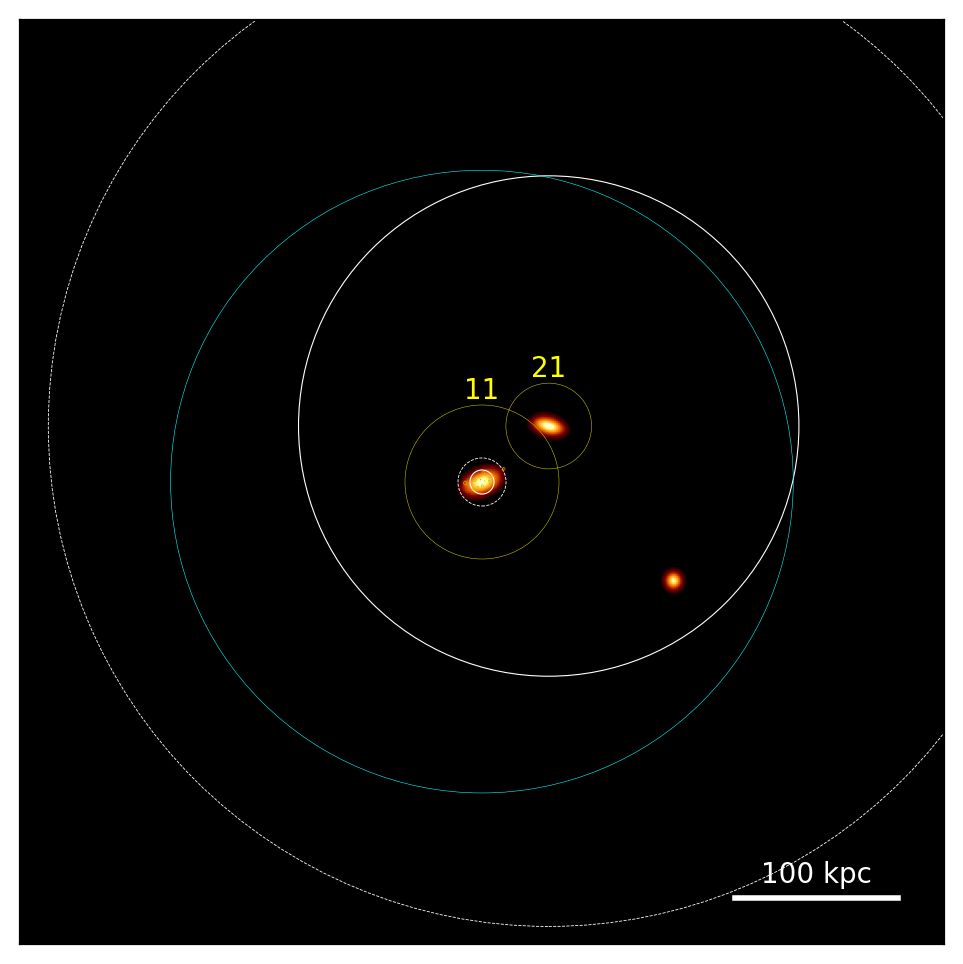

In [59]:
fig, ax = fancy_axis(figsize=(6,6), dpi=200)

painter.draw_partmap(snap1.part, ax=ax, cmap=plt.cm.afmhot)

cgals = cut_box(gal1s, target['x'], target['y'], target['z'], 3*target['r200_code'], both_sphere=True)
for cgal in cgals:
    color = 'orange' if(cgal['r'] < target['r']) else 'yellow'
    cir = plt.Circle((cgal['x'], cgal['y']), cgal['r'], color='y', fill=False, ls='-', lw=0.2)
    ax.add_artist(cir)
    if(cgal['level'] < 2)or(cgal['id'] in MWA1s['id']):
        if(cgal['id'] in MWA1s['id']):
            fontsize = 10 
            color='yellow'
            MWA = MWA1s[MWA1s['id'] == cgal['id']][0]
            cir = plt.Circle((MWA['x'], MWA['y']), MWA['r200_code'], color='w', fill=False, ls='-', lw=0.4)
            ax.add_artist(cir)
            cir = plt.Circle((MWA['x'], MWA['y']), 2*MWA['r200_code'], color='w', fill=False, ls='--', lw=0.3)
            ax.add_artist(cir)
        else:
            fontsize = 6
            color = 'orange'
        ax.text(cgal['x'], cgal['y']+cgal['r'], f"{cgal['id']}", color=color, fontsize=fontsize, ha='center', va='bottom')

chals = cut_box(hal1s, target['x'], target['y'], target['z'], 3*target['r200_code'], both_sphere=True, rname='rvir')
chals = chals[chals['level'] <= 2]
for chal in chals:
    color = 'b' if(chal['rvir'] < target['r200_code']) else 'cyan'
    cir = plt.Circle((chal['x'], chal['y']), chal['rvir'], color=color, fill=False, ls='-', lw=0.2)
    ax.add_artist(cir)

add_scalebar(ax, snap1.unit_l)

## Solution: Recalc virial

# ID 46
Near massive??


In [50]:
LG[46]['neighbor']

array([], dtype=[('id', '<i4'), ('mratio', '<f8')])

In [51]:
target = bggs[bggs['id'] == 46][0]
target.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?'), ('r200', '<f8'), ('m200', '<f8'), ('r200_code', '<f8'), (

In [52]:
snap1.set_box_halo(target, radius=3, radius_name='r200_code')
snap1.get_part(pname='star', nthread=32)
print(snap1.part.shape)

(3287648,)


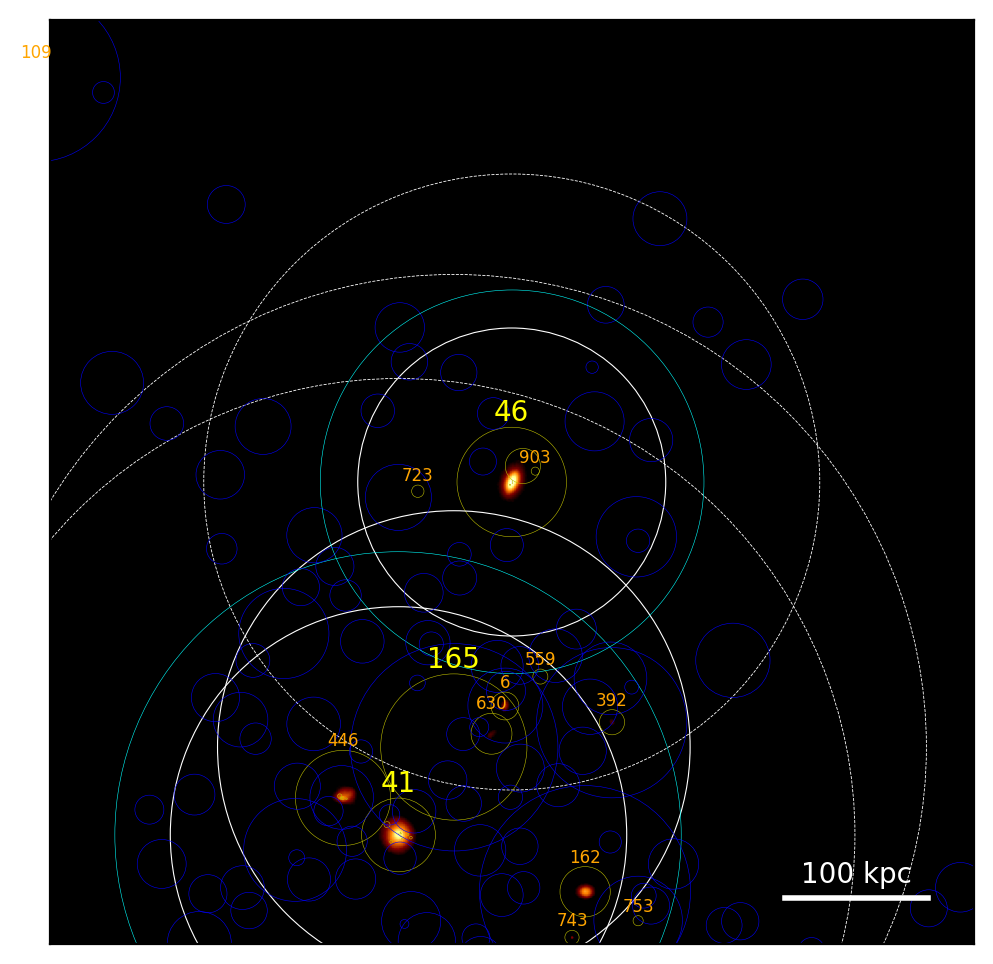

In [54]:
fig, ax = fancy_axis(figsize=(6,6), dpi=200)

painter.draw_partmap(snap1.part, ax=ax, cmap=plt.cm.afmhot)

cgals = cut_box(gal1s, target['x'], target['y'], target['z'], 3*target['r200_code'], both_sphere=True)
for cgal in cgals:
    color = 'orange' if(cgal['r'] < target['r']) else 'yellow'
    cir = plt.Circle((cgal['x'], cgal['y']), cgal['r'], color='y', fill=False, ls='-', lw=0.2)
    ax.add_artist(cir)
    if(cgal['level'] < 2)or(cgal['id'] in MWA1s['id']):
        if(cgal['id'] in MWA1s['id']):
            fontsize = 10 
            color='yellow'
            MWA = MWA1s[MWA1s['id'] == cgal['id']][0]
            cir = plt.Circle((MWA['x'], MWA['y']), MWA['r200_code'], color='w', fill=False, ls='-', lw=0.4)
            ax.add_artist(cir)
            cir = plt.Circle((MWA['x'], MWA['y']), 2*MWA['r200_code'], color='w', fill=False, ls='--', lw=0.3)
            ax.add_artist(cir)
        else:
            fontsize = 6
            color = 'orange'
        ax.text(cgal['x'], cgal['y']+cgal['r'], f"{cgal['id']}", color=color, fontsize=fontsize, ha='center', va='bottom')

chals = cut_box(hal1s, target['x'], target['y'], target['z'], 3*target['r200_code'], both_sphere=True, rname='rvir')
chals = chals[chals['level'] <= 2]
for chal in chals:
    color = 'b' if(chal['rvir'] < target['r200_code']) else 'cyan'
    cir = plt.Circle((chal['x'], chal['y']), chal['rvir'], color=color, fill=False, ls='-', lw=0.2)
    ax.add_artist(cir)

add_scalebar(ax, snap1.unit_l)

## Solution: Reallocate to group

# ID 68

In [68]:
gid = 68
print( LG[gid]['neighbor'] )
target = bggs[bggs['id'] == gid][0]

snap1.set_box_halo(target, radius=4, radius_name='r200_code')
snap1.get_part(pname='star', nthread=32)
print(snap1.part.shape)

[]
(11059276,)


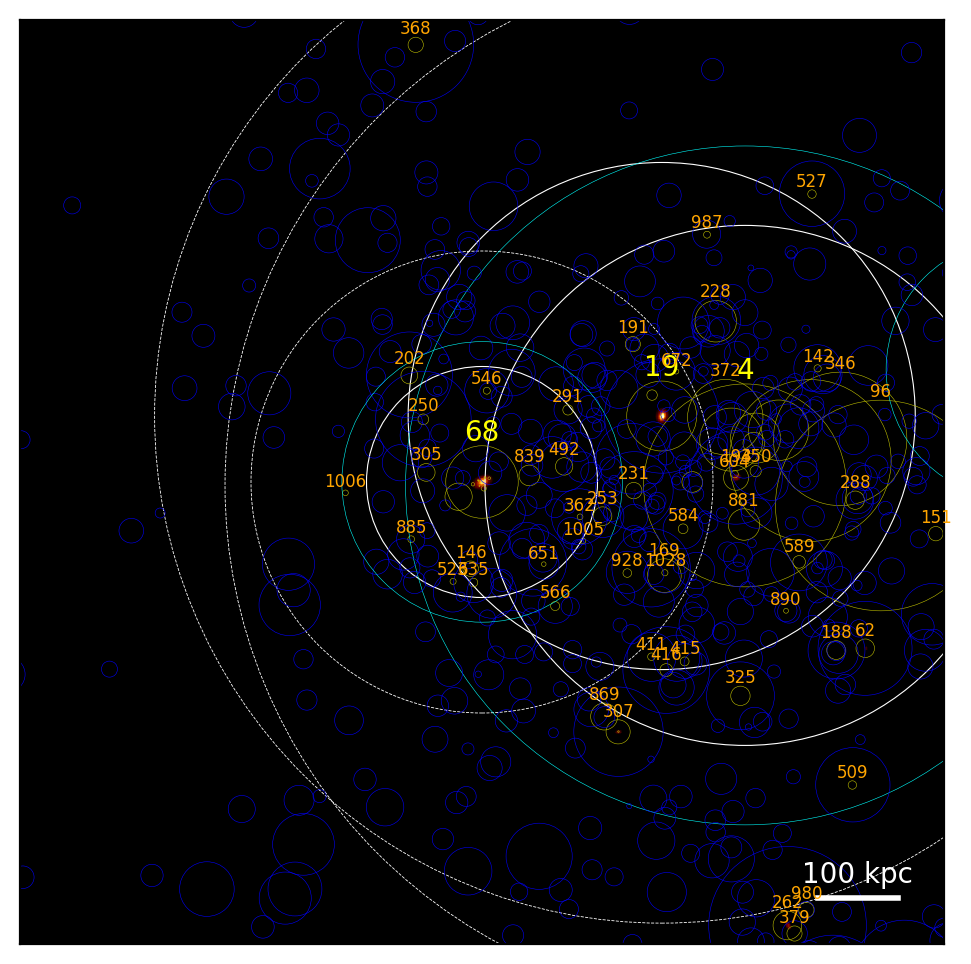

In [69]:
fig, ax = fancy_axis(figsize=(6,6), dpi=200)

painter.draw_partmap(snap1.part, ax=ax, cmap=plt.cm.afmhot)

cgals = cut_box(gal1s, target['x'], target['y'], target['z'], 4*target['r200_code'], both_sphere=True)
for cgal in cgals:
    color = 'orange' if(cgal['r'] < target['r']) else 'yellow'
    cir = plt.Circle((cgal['x'], cgal['y']), cgal['r'], color='y', fill=False, ls='-', lw=0.2)
    ax.add_artist(cir)
    if(cgal['level'] < 2)or(cgal['id'] in MWA1s['id']):
        if(cgal['id'] in MWA1s['id']):
            fontsize = 10 
            color='yellow'
            MWA = MWA1s[MWA1s['id'] == cgal['id']][0]
            cir = plt.Circle((MWA['x'], MWA['y']), MWA['r200_code'], color='w', fill=False, ls='-', lw=0.4)
            ax.add_artist(cir)
            cir = plt.Circle((MWA['x'], MWA['y']), 2*MWA['r200_code'], color='w', fill=False, ls='--', lw=0.3)
            ax.add_artist(cir)
        else:
            fontsize = 6
            color = 'orange'
        ax.text(cgal['x'], cgal['y']+cgal['r'], f"{cgal['id']}", color=color, fontsize=fontsize, ha='center', va='bottom')

chals = cut_box(hal1s, target['x'], target['y'], target['z'], 4*target['r200_code'], both_sphere=True, rname='rvir')
chals = chals[chals['level'] <= 2]
for chal in chals:
    color = 'b' if(chal['rvir'] < target['r200_code']) else 'cyan'
    cir = plt.Circle((chal['x'], chal['y']), chal['rvir'], color=color, fill=False, ls='-', lw=0.2)
    ax.add_artist(cir)

add_scalebar(ax, snap1.unit_l)

# ID 104

In [60]:
gid = 104
print( LG[gid]['neighbor'] )
target = bggs[bggs['id'] == gid][0]

snap1.set_box_halo(target, radius=3, radius_name='r200_code')
snap1.get_part(pname='star', nthread=32)
print(snap1.part.shape)

[]
(10313244,)


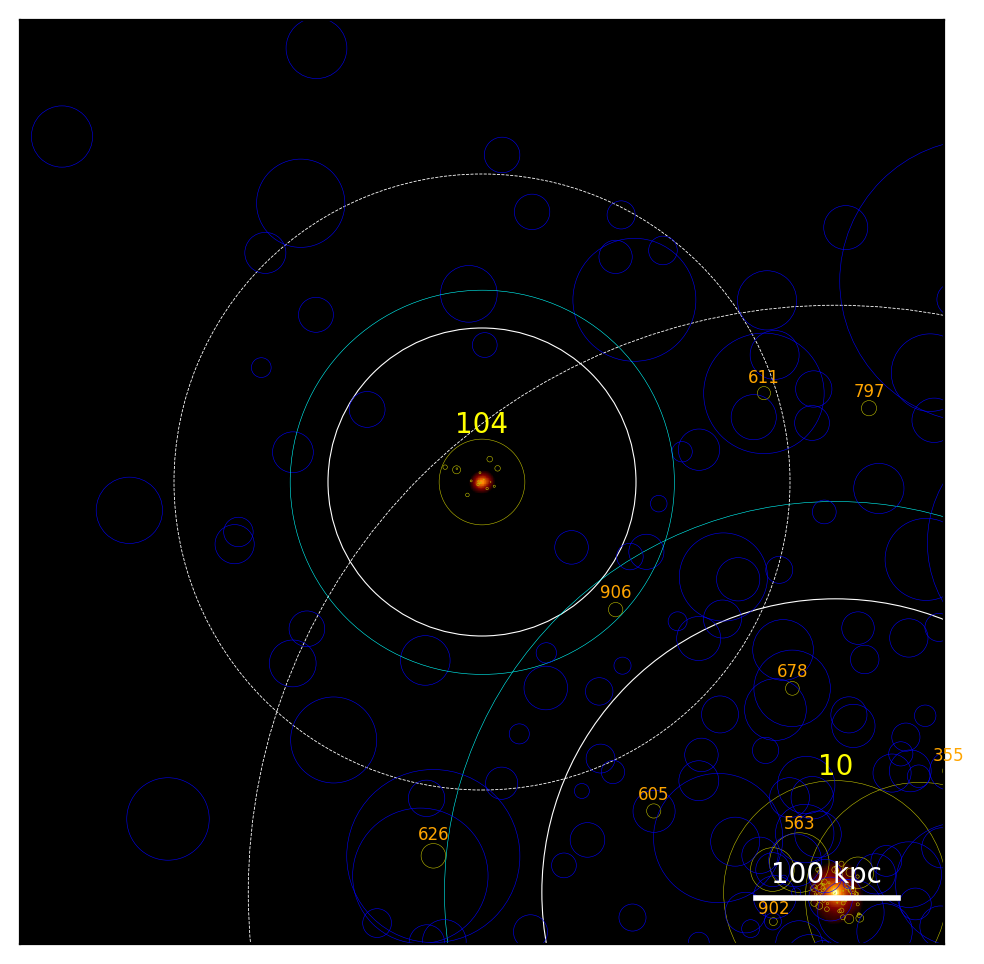

In [61]:
fig, ax = fancy_axis(figsize=(6,6), dpi=200)

painter.draw_partmap(snap1.part, ax=ax, cmap=plt.cm.afmhot)

cgals = cut_box(gal1s, target['x'], target['y'], target['z'], 3*target['r200_code'], both_sphere=True)
for cgal in cgals:
    color = 'orange' if(cgal['r'] < target['r']) else 'yellow'
    cir = plt.Circle((cgal['x'], cgal['y']), cgal['r'], color='y', fill=False, ls='-', lw=0.2)
    ax.add_artist(cir)
    if(cgal['level'] < 2)or(cgal['id'] in MWA1s['id']):
        if(cgal['id'] in MWA1s['id']):
            fontsize = 10 
            color='yellow'
            MWA = MWA1s[MWA1s['id'] == cgal['id']][0]
            cir = plt.Circle((MWA['x'], MWA['y']), MWA['r200_code'], color='w', fill=False, ls='-', lw=0.4)
            ax.add_artist(cir)
            cir = plt.Circle((MWA['x'], MWA['y']), 2*MWA['r200_code'], color='w', fill=False, ls='--', lw=0.3)
            ax.add_artist(cir)
        else:
            fontsize = 6
            color = 'orange'
        ax.text(cgal['x'], cgal['y']+cgal['r'], f"{cgal['id']}", color=color, fontsize=fontsize, ha='center', va='bottom')

chals = cut_box(hal1s, target['x'], target['y'], target['z'], 3*target['r200_code'], both_sphere=True, rname='rvir')
chals = chals[chals['level'] <= 2]
for chal in chals:
    color = 'b' if(chal['rvir'] < target['r200_code']) else 'cyan'
    cir = plt.Circle((chal['x'], chal['y']), chal['rvir'], color=color, fill=False, ls='-', lw=0.2)
    ax.add_artist(cir)

add_scalebar(ax, snap1.unit_l)

## No need to solution